In [2]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
props_as_ds = exp.props_as_ds(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_ds_uncat)
ds = exp.ds
da = exp.ds["s"]

jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=N_WORKERS, chunksize=100)
props_as_ds["nao"] = get_nao(props_as_ds)
overlap = (jet_pos_da > 0).any("lat").all("jet")
props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")

# Woollings et al 2018

In [3]:
for freq in ["1D", "2D", "7D", "14D", "1MS", "1YS"]:
    x = props_as_ds["mean_lat"].resample(time=freq).std().values
    y = props_as_ds["spe_star"].resample(time=freq).mean().values

    x1, y1 = x[:, 0], y[:, 0]
    x2, y2 = x[:, 1], y[:, 1]
    sub = np.corrcoef(x1[~np.isnan(x1)], y1[~np.isnan(y1)])[0, 1]
    extra = np.corrcoef(x2[~np.isnan(x2)], y2[~np.isnan(y2)])[0, 1]
    print(f"{freq}, {sub=:.2f}, {extra=:.2f}")

1D, sub=-0.11, extra=-0.05
2D, sub=-0.12, extra=-0.05
7D, sub=-0.19, extra=-0.03
14D, sub=-0.25, extra=-0.02
1MS, sub=-0.37, extra=-0.02
1YS, sub=-0.33, extra=0.06


Text(0, 0.5, 'Jet lat. std')

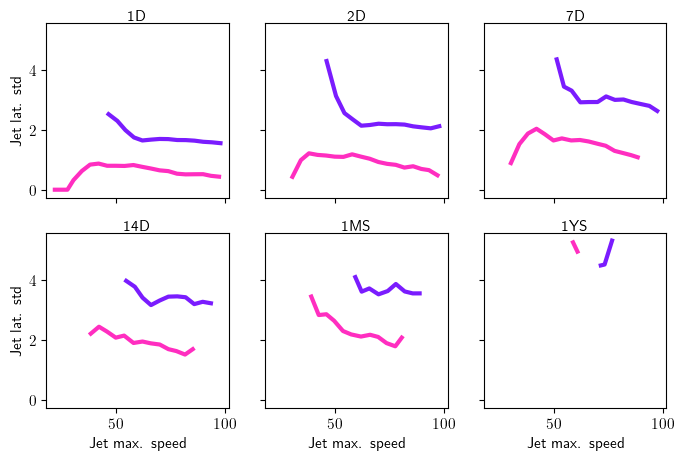

In [4]:
plt.ion()
fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharex="all", sharey="all")
for ax, freq in zip(axes.ravel(), ["1D", "2D", "7D", "14D", "1MS", "1YS"]):
    x = props_as_ds["spe_star"].resample(time=freq).mean().values
    y = props_as_ds["mean_lat"].resample(time=freq).std().values
    bins = np.arange(0, 101, 4)
    labels = np.digitize(x, bins)
    unique_labels = np.arange(len(bins))
    masks = labels[..., None] == unique_labels[None, None, :]
    for j, jet in enumerate(SHORTHAND):
        color = COLORS[2 - j]
        x_ = []
        y_ = []
        for mask in masks.T:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                x_.append(np.mean(x[mask[j, :], j], axis=0))
                y_.append(np.mean(y[mask[j, :], j], axis=0))
        ax.plot(x_, y_, color=color, lw=3)
    ax.set_title(freq, pad=2)
axes[1, 0].set_xlabel("Jet max. speed")
axes[1, 1].set_xlabel("Jet max. speed")
axes[1, 2].set_xlabel("Jet max. speed")
axes[0, 0].set_ylabel("Jet lat. std")
axes[1, 0].set_ylabel("Jet lat. std")
    # x, y = np.asarray(x_), np.asarray(y_)

# COM speed tests

In [8]:
props_over_time = exp.props_over_time(all_jets_over_time, props_as_ds_uncat)

Props over time


In [9]:
dla = props_over_time["mean_lat"].differentiate("point").values
dlo = props_over_time["mean_lon"].differentiate("point").values
la = props_over_time["mean_lat"].values
dt = props_over_time["time"].differentiate("point").values / 1e9
com_speed = haversine_v2(la, dlo, dla) / dt


In [10]:
props_over_time

<xarray.Dataset> Size: 1GB
Dimensions:          (jet: 69581, point: 106)
Coordinates:
  * point            (point) int64 848B 0 1 2 3 4 5 ... 100 101 102 103 104 105
Dimensions without coordinates: jet
Data variables: (12/22)
    mean_lon         (jet, point) float64 59MB -64.0 -64.33 -60.96 ... nan nan
    mean_lat         (jet, point) float64 59MB 33.28 34.47 31.8 ... nan nan nan
    mean_lev         (jet, point) float64 59MB ...
    Lon              (jet, point) float64 59MB ...
    Lat              (jet, point) float64 59MB ...
    Spe              (jet, point) float64 59MB ...
    ...               ...
    int              (jet, point) float64 59MB ...
    jet_index        (jet, point) int64 59MB ...
    is_polar         (jet, point) float64 59MB ...
    time             (jet, point) datetime64[ns] 59MB 1959-01-01 ... NaT
    persistence      (jet, point) float64 59MB ...
    com_speed        (jet, point) float64 59MB ...

In [11]:
com_speed.shape

(69581, 106)

(array([335687.,  16593.,   1520.,    183.,     22.,      1.,      2.,
             0.,      3.,      1.]),
 array([  0.00832,  46.27906,  92.5498 , 138.82054, 185.09128, 231.36201,
        277.63275, 323.90349, 370.17423, 416.44497, 462.71571]),
 <BarContainer object of 10 artists>)

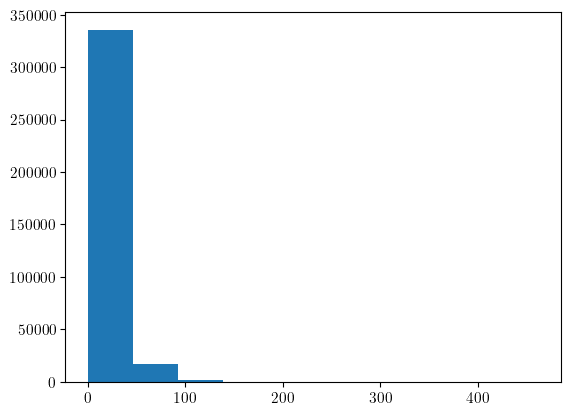

In [12]:
com_speed = haversine_v2(la, dlo, dla) / dt
plt.hist(com_speed.flatten())

# Histograms

In [57]:
from math import log10, floor
from matplotlib.ticker import FormatStrFormatter

def props_histogram(data_vars: list, props_as_ds: xr.Dataset, season: str | None = None, nrows: int = 3, ncols: int = 4, clear: bool = True, suffix: str = ""):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*2.4), tight_layout=True)
    axes = axes.flatten()
    if season is not None:
        month_list = SEASONS[season]
        season_mask = np.isin(props_as_ds.time.dt.month.values, month_list)
        props_as_ds_ = props_as_ds.sel(time=season_mask)
    else:
        props_as_ds_ = props_as_ds

    for i, (varname, ax) in enumerate(zip(data_vars, axes)):
        if varname == "mean_lev":
            ax.invert_xaxis()
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        maxx = {}
        for j, jet in enumerate(["subtropical", "polar"]):
            try:
                this_da = props_as_ds_[varname].sel(jet=jet)
                x = np.linspace(this_da.min(), this_da.max(), 1000)
                y = gaussian_kde(this_da.interpolate_na("time", fill_value="extrapolate").values)(x) * len(this_da)
                ax.plot(x, y, color=COLORS[2 - j], linewidth=2)
                ax.fill_between(x, 0, y, color=COLORS[2 - j], linewidth=1, alpha=0.3)
                maxx_ = x[np.argmax(y)]
                maxx[jet] = round(maxx_, -int(floor(log10(abs(maxx_)))) + 2)
            except KeyError:
                this_da = props_as_ds_[varname]
                x = np.linspace(this_da.min(), this_da.max(), 1000)
                y = gaussian_kde(this_da.interpolate_na("time", fill_value="extrapolate").values)(x) * len(this_da)
                ax.plot(x, y, color="black", linewidth=2)
                ax.fill_between(x, 0, y, color="black", linewidth=1, alpha=0.3)
                break
        if len(maxx) > 0:
            current_ticks = ax.get_xticks()
            xticks = ax.set_xticks(np.concatenate([current_ticks, list(maxx.values())]))
            xticks[-1]._apply_params(color=COLORS[1], labelcolor=COLORS[1], length=12, width=3, pad=14)
            pad = 14 if varname in ["mean_lat", "mean_lev", "spe_star", "waviness1"] else 25
            xticks[-2]._apply_params(color=COLORS[2], labelcolor=COLORS[2], length=12, width=3, pad=pad)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    fig.savefig(f"{FIGURES}/jet_props_hist/{season}{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

In [58]:
data_vars = ["waviness1", "waviness2", "wavinessR16", "wavinessDC16", "wavinessFV15", "tilt"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    props_histogram(data_vars, props_as_ds, season, nrows=2, ncols=3, clear=True, suffix="_waviness")

In [59]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_spe", "spe_star", "tilt", "waviness1", "wavinessR16", "wavinessDC16", "wavinessFV15", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    props_histogram(data_vars, props_as_ds, season, nrows=4, ncols=4, clear=True)

In [60]:
data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    props_histogram(data_vars, props_as_ds, season, nrows=2, ncols=3, clear=True, suffix="_subset")

# Trends

In [4]:
def plot_trends(data_vars: list, props_as_ds: xr.Dataset, season: str | None = None, std: bool = False, nrows: int = 3, ncols: int = 4, clear: bool = True, suffix: str = ""):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*2.4), tight_layout=True, sharex="all")
    axes = axes.flatten()
    if season is not None:
        month_list = SEASONS[season]
        season_mask = np.isin(props_as_ds.time.dt.month.values, month_list)
        props_as_ds = props_as_ds.sel(time=season_mask)
    else:
        season = "all_year"
    if std:
        props_as_ds = props_as_ds[data_vars].resample(time="1YE").std()
    else:
        props_as_ds = props_as_ds[data_vars].resample(time="1YE").mean()
    x = props_as_ds.time.dt.year.values
    for i, (varname, ax) in enumerate(zip(data_vars, axes)):
        if varname == "mean_lev":
            ax.invert_yaxis()
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        for j, jet in enumerate(["subtropical", "polar"]):
            try:
                this_da = props_as_ds[varname].sel(jet=jet)
                ax.plot(x, this_da.values, lw=2, color=COLORS[2 - j])
                c1, c0, _, p, _ = linregress(x, this_da.values)
                if p < 0.05:
                    ls = "dashed"
                else:
                    ls = "dotted"
                ax.plot(
                    x,
                    c1 * x + c0,
                    lw=1.5,
                    color=COLORS[2 - j],
                    ls=ls,
                    label=f"{SHORTHAND[jet]}., {p_to_tex(c1, c0)}, $p={p:.2f}$",
                )
            except KeyError:
                this_da = props_as_ds[varname]
                ax.plot(x, this_da.values, lw=2, color="black")
                c1, c0, _, p, _ = linregress(x, this_da.values)
                if p < 0.05:
                    ls = "dashed"
                else:
                    ls = "dotted"
                ax.plot(x, c1 * x + c0, lw=1.5, color="black", ls=ls, label=f"{p_to_tex(c1, c0)}, $p={p:.2f}$")
                break
        ax.legend(ncol=1, fontsize=10)
    subtitle = "std" if std else "trends"
    fig.savefig(f"{FIGURES}/jet_props_trends/jet_props_{subtitle}_{season}{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

In [54]:
data_vars = ["waviness1", "waviness2", "wavinessR16", "wavinessDC16", "wavinessFV15", "tilt"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_ds, season, nrows=2, ncols=3, clear=True, suffix="_waviness")

In [55]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_spe", "spe_star", "tilt", "waviness1", "wavinessR16", "wavinessDC16", "wavinessFV15", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_ds, season, nrows=4, ncols=4, clear=True)

In [56]:
data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_ds, season, nrows=2, ncols=3, clear=True, suffix="_subset")

In [32]:
# data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
# factors = {
#     "mean_lat": 0.001,
#     "spe_star": 0.01,
#     "com_speed": 0.001,
#     "wavinessR16": 0.0001,
#     "width": 1000,
#     "double_jet_index": 0.0001,
# }
factors = {
    "mean_lon": 0.001,
    "mean_lat": 0.001,
    "mean_lev": 0.01,
    "spe_star": 0.01,
    "mean_spe": 0.01,
    "tilt": 0.0001,
    "waviness1": 0.0001,
    "wavinessR16": 0.0001,
    "wavinessDC16": 0.0001,
    "wavinessFV15": 0.00001,
    "width": 1000,
    "int": 1e5,
    "int_over_europe": 1e5,
    "persistence": 0.001,
    "com_speed": 0.001,
    "double_jet_index": 0.0001,
}
data_vars = list(factors)
# data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_spe", "spe_star", "tilt", "waviness1", "wavinessR16", "wavinessDC16", "wavinessFV15", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]
# data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_spe", "spe_star", "tilt", "waviness1", "wavinessR16", "wavinessDC16", "wavinessFV15", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]

props_as_ds_reduced = props_as_ds.sel(time=props_as_ds.time.dt.year >= 1979)
jets = props_as_ds.jet.values
seasons = list(SEASONS).copy()
seasons.append("Year")
periods = ["1959-", "1979-"]
iterables = [seasons, periods]
columns = pd.MultiIndex.from_product(iterables, names=["Season", "Period"])
iterables = [[PRETTIER_VARNAME[varname] for varname in data_vars], [SHORTHAND[jet] for jet in jets]]
index = pd.MultiIndex.from_product(iterables, names=["Property", "Jet"])
df = pd.DataFrame(np.zeros((len(index), len(columns)), dtype="str"), index=index, columns=columns)
for season in seasons:
    for reduced, period in zip([False, True], periods):
        if reduced:
            pads = props_as_ds_reduced
        else:
            pads = props_as_ds
        season_ = None if season == "Year" else season
        pads = extract_season(pads, season_)
        pads = pads[data_vars].resample(time="1YE").mean()
        x = pads.time.dt.year.values
        for varname, factor in factors.items():
            for jet in jets:
                try:
                    this_da = pads[varname].sel(jet=jet)
                    c1, c0, _, p, _ = linregress(x, this_da.values)
                except KeyError:
                    this_da = pads[varname]
                    c1, c0, _, p, _ = linregress(x, this_da.values)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
                    indexer1 = ((PRETTIER_VARNAME[varname], SHORTHAND[jet]), (season, period))
                    str_start = r"${" if p > 0.05 else r"$\mathbf{"
                    str_ = str_start + num2tex(c1 / factor, ncomma=2) + r"}$"
                    # df.loc[*indexer1] = f"{c1:.2f} ({p:.2f})"
                    df.loc[*indexer1] = str_
suffix = "_extended" if len(factors) > 6 else ""
df.to_latex(buf=f"persistent-extremes-era5/out{suffix}.tex", escape=False, column_format="l", multirow=False, header=True, index_names=False)

In [43]:
for varname in data_vars:
    s = r"$[10^{" + f"{np.log10(factors[varname]):.0f}" + r"}" f"{UNITS[varname].strip('$')}" + r" / \mathrm{year}]$"
    print(s)

$[10^{-3}~^{\circ} \mathrm{E} / \mathrm{year}]$
$[10^{-3}~^{\circ} \mathrm{N} / \mathrm{year}]$
$[10^{-2}\mathrm{hPa} / \mathrm{year}]$
$[10^{-2}\mathrm{m} \cdot \mathrm{s}^{-1} / \mathrm{year}]$
$[10^{-2}\mathrm{m} \cdot \mathrm{s}^{-1} / \mathrm{year}]$
$[10^{-4}~^{\circ} \mathrm{N} / ~^{\circ} \mathrm{E} / \mathrm{year}]$
$[10^{-4}~^{\circ} \mathrm{N} / ~^{\circ} \mathrm{E} / \mathrm{year}]$
$[10^{-4}~^{\circ} \mathrm{N} / ~^{\circ} \mathrm{E} / \mathrm{year}]$
$[10^{-4}~ / \mathrm{year}]$
$[10^{-5}~ / \mathrm{year}]$
$[10^{3}\mathrm{m} / \mathrm{year}]$
$[10^{5}\mathrm{m}^2 \cdot \mathrm{s}^{-1} / \mathrm{year}]$
$[10^{5}\mathrm{m}^2 \cdot \mathrm{s}^{-1} / \mathrm{year}]$
$[10^{-3}\mathrm{day} / \mathrm{year}]$
$[10^{-3}\mathrm{m} \cdot \mathrm{s}^{-1} / \mathrm{year}]$
$[10^{-4}~ / \mathrm{year}]$


In [28]:
s

'$10^{-4.0}~$'

# Trends in Variability

In [61]:
data_vars = ["waviness1", "waviness2", "wavinessR16", "wavinessDC16", "wavinessFV15", "tilt"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_ds, season, std=True, nrows=2, ncols=3, clear=True, suffix="_waviness")

In [62]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_spe", "spe_star", "tilt", "waviness1", "wavinessR16", "wavinessDC16", "wavinessFV15", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_ds, season, std=True, nrows=4, ncols=4, clear=True)

In [63]:
data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_ds, season, std=True, nrows=2, ncols=3, clear=True, suffix="_subset")

# Correlations

In [14]:
plt.ion()
clear_output()

In [15]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da.reset_coords("lev", drop=True)

In [16]:
season_mask = (props_as_ds.time.dt.season == "JJA")
props_as_ds_late = props_as_ds.sel(time=season_mask)
props_as_ds_late["anti_pv_activity"] = da_pvs.sel(type="anti").sum(dim=["lon", "lat"])
props_as_ds_late["cycl_pv_activity"] = da_pvs.sel(type="cycl").sum(dim=["lon", "lat"])
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)

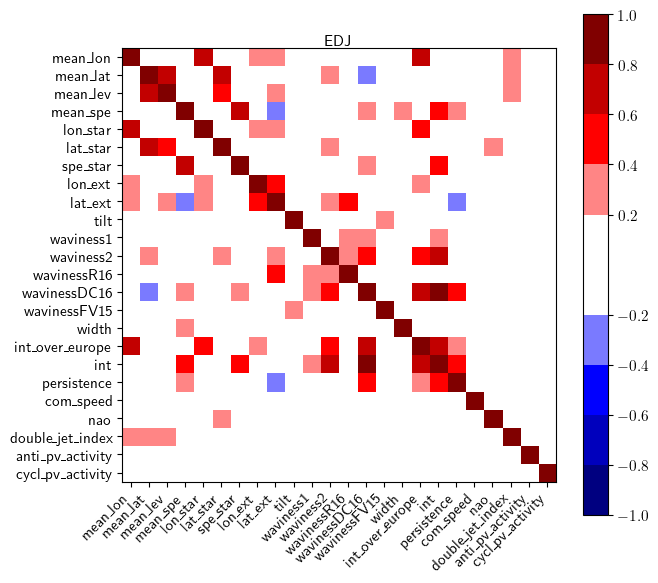

In [17]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="polar").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        to_concat.append(da.sel(jet="polar").fillna(DEFAULT_VALUES.get(varname, 0)).values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("EDJ")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_polar.png")

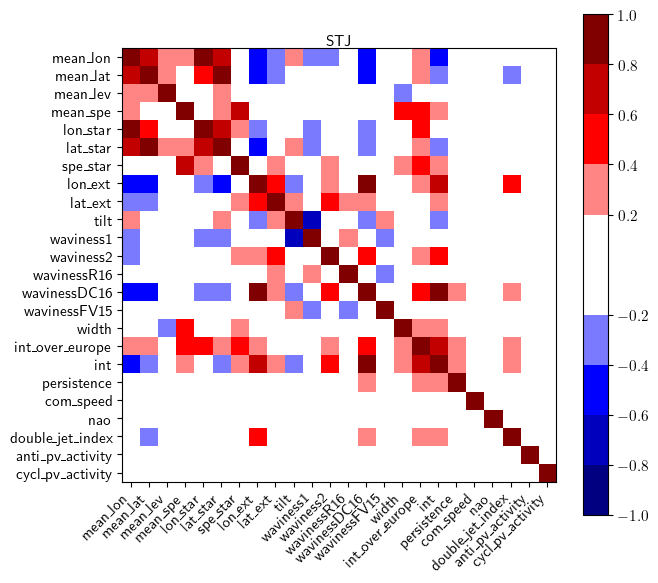

In [18]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="subtropical").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index"
    ]:
        to_concat.append(da.sel(jet="subtropical").fillna(DEFAULT_VALUES.get(varname, 0)).values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("STJ")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_subtropical.png")

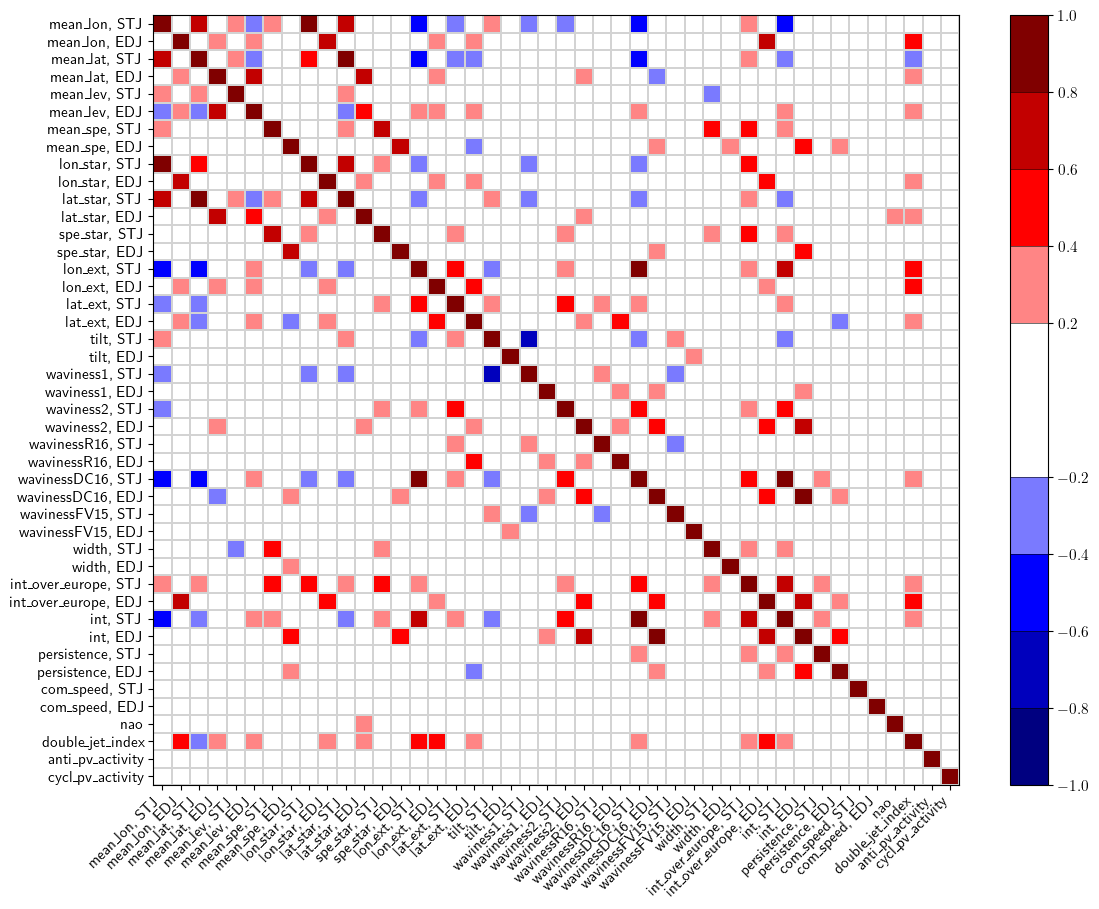

In [19]:
to_concat = []
ticks = []
valids = props_as_ds_late["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full.png")

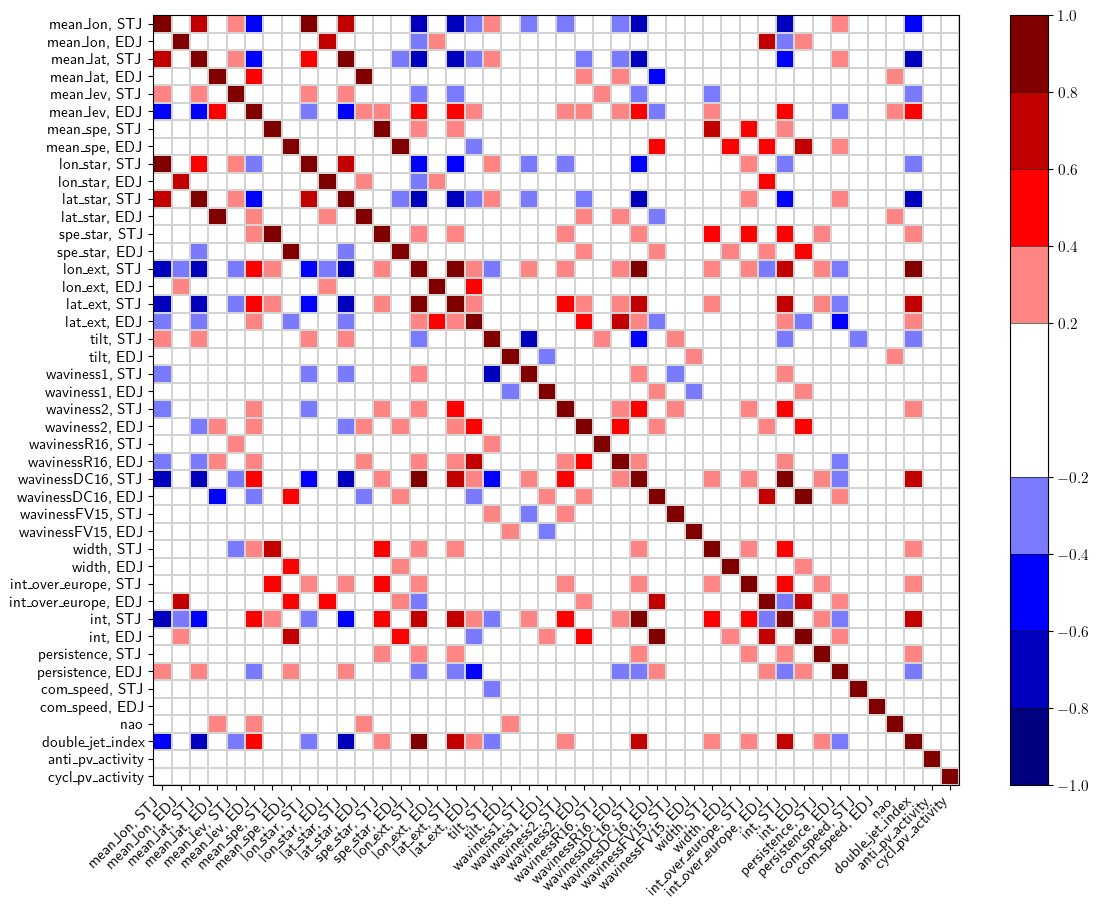

In [20]:
to_concat = []
ticks = []
freq = "1W"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png")

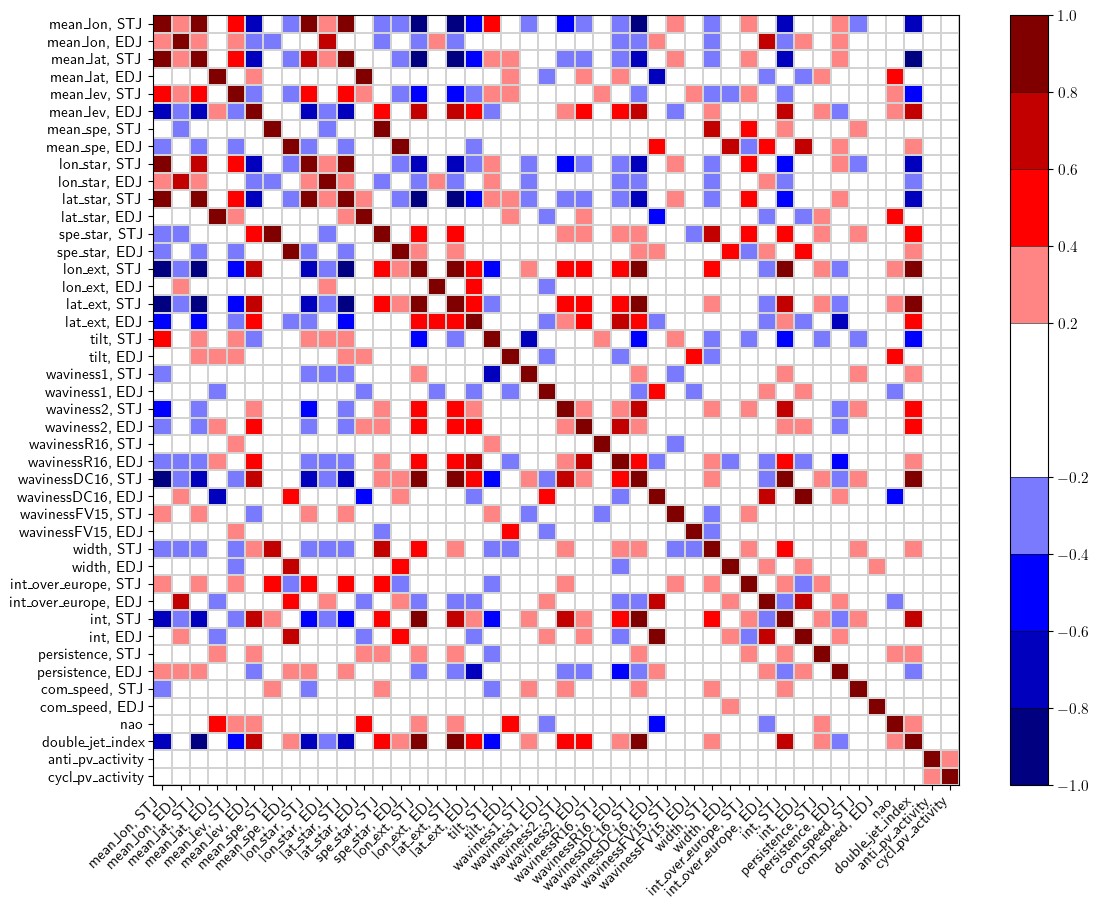

In [21]:
to_concat = []
ticks = []
freq = "1ME"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png")

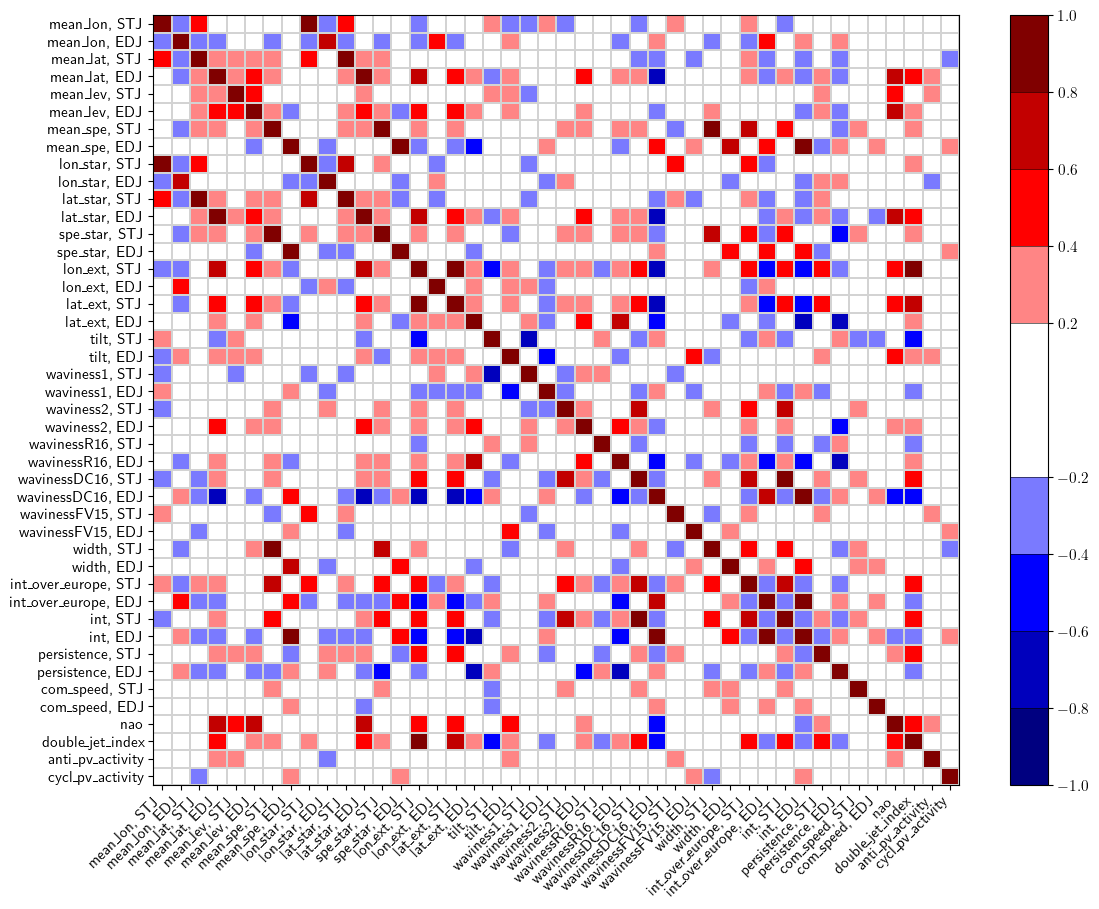

In [22]:
to_concat = []
ticks = []
freq = "1YE"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids])
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png")

# Seasonal variability ?

In [85]:
from matplotlib.dates import DateFormatter, MonthLocator
def plot_seasonal(data_vars: list, props_as_ds: xr.Dataset, nrows: int = 3, ncols: int = 4, clear: bool = True, suffix: str = ""):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*2.4), tight_layout=True, sharex="all")
    axes = axes.flatten()
    winsize = 15
    halfwinsize = int(np.ceil(winsize / 2))
    jets = props_as_ds.jet.values
    for varname, ax in zip(data_vars, axes.ravel()):
        try:
            gb = props_as_ds[varname].groupby("time.dayofyear")
        except KeyError:
            continue
        x = list(gb.groups.keys())
        x = DATERANGE[x]
        ys = gb.mean()
        ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
        ys = ys.rolling(dayofyear=15, center=True, min_periods=1).mean()
        ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)}).values
        qs = gb.quantile(q=[0.25, 0.75]).values
        median = gb.median()
        median = median.pad({"dayofyear": halfwinsize}, mode="wrap")
        median = median.rolling(dayofyear=15, center=True, min_periods=1).mean()
        median = median.isel({"dayofyear": slice(halfwinsize, -halfwinsize)}).values
        if ys.ndim == 1:
            ax.fill_between(x, qs[:, 0], qs[:, 1], color="black", alpha=0.2)
            ax.plot(x, median, lw=2, color="black", ls="dotted")
            ax.plot(x, ys, lw=3, color="black")
        else:
            for i in range(2):
                ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=COLORS[2 - i], alpha=0.2, zorder=-10)
                ax.plot(x, median[:, i], lw=2, color=COLORS[2 - i], ls="dotted", zorder=0)
                ax.plot(x, ys[:, i], lw=3, color=COLORS[2 - i], label=SHORTHAND[jets[i]], zorder=10)
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]")
        ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
        ax.xaxis.set_major_formatter(DateFormatter("%b"))
        ax.set_xlim(min(x), max(x))
        if varname == "mean_lev":
            ax.invert_yaxis()
        ylim = ax.get_ylim()
        wherex = np.isin(x.month, [6, 7, 8])
        ax.fill_between(x, *ylim, where=wherex, alpha=0.1, color="black", zorder=-10)
        ax.set_ylim(ylim)
    axes.ravel()[0].legend().set_zorder(102)
    plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

In [45]:
data_vars = ["waviness1", "waviness2", "wavinessR16", "wavinessDC16", "wavinessFV15", "tilt"]
plot_seasonal(data_vars, props_as_ds, nrows=2, ncols=3, clear=True, suffix="_waviness")

In [86]:
data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
plot_seasonal(data_vars, props_as_ds, nrows=2, ncols=3, clear=True, suffix="_subset")

In [48]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_spe", "spe_star", "tilt", "waviness1", "wavinessR16", "wavinessDC16", "wavinessFV15", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]
plot_seasonal(data_vars, props_as_ds, nrows=4, ncols=4, clear=True)

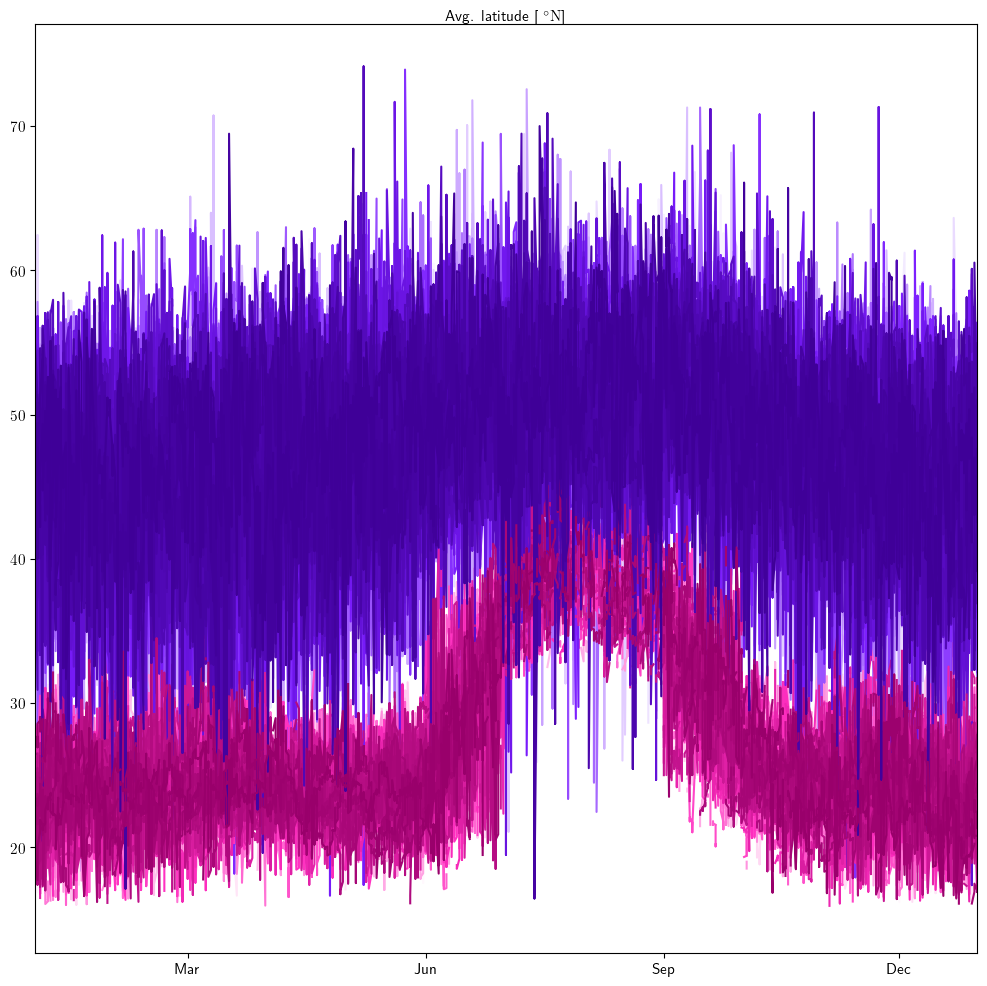

In [40]:
from matplotlib.dates import DateFormatter, MonthLocator
# data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
data_vars = ["mean_lat"]
nrows = 1
ncols = 1
plt.ion()
plt.show()
clear_output()
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10), tight_layout=True, sharex="all")
axes = np.atleast_2d(axes).flatten()
winsize = 15
halfwinsize = int(np.ceil(winsize / 2))
jets = props_as_ds.jet.values
for varname, ax in zip(data_vars, axes.ravel()):
    colors_sub = MYPINKS(np.linspace(0, 1, len(YEARS)))
    colors_extra = MYPURPLES(np.linspace(0, 1, len(YEARS)))
    colors_other = colormaps.greys(np.linspace(0, 1, len(YEARS)))
    to_plot = props_as_ds[varname]
    try:
        sub = to_plot.sel(jet="subtropical")
        extra = to_plot.sel(jet="polar")
        for i, year in enumerate(YEARS):
            sub_ = sub.sel(time=sub.time.dt.year==year)
            extra_ = extra.sel(time=extra.time.dt.year==year)
            x = pd.to_datetime(extra_.time.dt.dayofyear.values, format='%j')
            ax.plot(x, sub_, color=colors_sub[i])
            ax.plot(x, extra_, color=colors_extra[i])
    except KeyError:
        for i, year in enumerate(YEARS):
            to_plot_ = to_plot.sel(time=to_plot.time.dt.year==year)
            x = pd.to_datetime(to_plot_.time.dt.dayofyear.values, format='%j')
            ax.plot(x, to_plot_, color=colors_other[i])
#     x = list(gb.groups.keys())
#     x = DATERANGE[x]
#     ys = gb.mean()
#     ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
#     ys = ys.rolling(dayofyear=15, center=True, min_periods=1).mean()
#     ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)}).values
#     qs = gb.quantile(q=[0.33, 0.66]).values
#     median = gb.median()
#     median = median.pad({"dayofyear": halfwinsize}, mode="wrap")
#     median = median.rolling(dayofyear=15, center=True, min_periods=1).mean()
#     median = median.isel({"dayofyear": slice(halfwinsize, -halfwinsize)}).values
#     if ys.ndim == 1:
#         ax.fill_between(x, qs[:, 0], qs[:, 1], color="black", alpha=0.2)
#         ax.plot(x, median, lw=2, color="black", ls="dotted")
#         ax.plot(x, ys, lw=3, color="black")
#     else:
#         for i in range(2):
#             ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=COLORS[2 - i], alpha=0.2, zorder=-10)
#             ax.plot(x, median[:, i], lw=2, color=COLORS[2 - i], ls="dotted", zorder=0)
#             ax.plot(x, ys[:, i], lw=3, color=COLORS[2 - i], label=SHORTHAND[jets[i]], zorder=10)
    ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
# axes.ravel()[0].legend().set_zorder(102)

In [29]:
varname = "spe_star"
sub = props_as_ds[varname].sel(jet="subtropical")
extra = props_as_ds[varname].sel(jet="polar")

subs = []
extras = []
time_mask_ = np.isin(sub.time.dt.month, [7, 8])
for year in YEARS:
    time_mask = time_mask_ & (sub.time.dt.year==year)
    subs.append(sub.sel(time=time_mask).interpolate_na("time", method="nearest", fill_value="extrapolate").values)
    extras.append(extra.sel(time=time_mask).interpolate_na("time", method="nearest", fill_value="extrapolate").values)
subs = np.array(subs)
extras = np.array(extras)

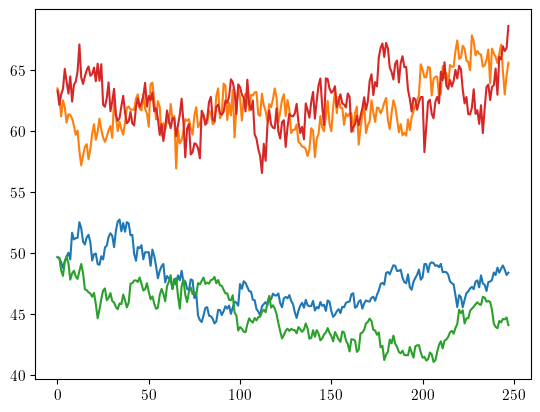

In [30]:
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.barycenters import *

# km = TimeSeriesKMeans(n_clusters=2, metric="euclidean")
gak_km = KernelKMeans(
    n_clusters=2,
    kernel="gak",
    kernel_params={"sigma": "auto"},
    n_init=20,
    verbose=False,
    random_state=77777,
)
labels = gak_km.fit_predict(np.stack([subs, extras], axis=2))

masks = labels_to_mask(labels)

for mask in masks.T:
    plt.plot(euclidean_barycenter(subs[mask]))
    plt.plot(euclidean_barycenter(extras[mask]))

# Dayofyear trend

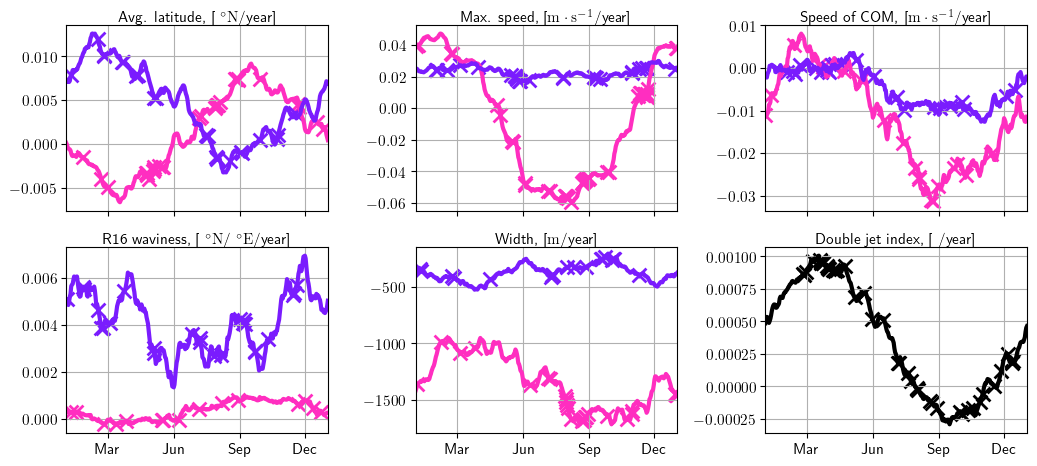

In [31]:
from matplotlib.dates import DateFormatter, MonthLocator
def get_trend(da):
    years = np.unique(da.time.dt.year)
    da = da.fillna(DEFAULT_VALUES[da.name])
    if "jet" not in da.dims:
        result = linregress(years, da.values)
        return xr.Dataset({"slope": result.slope, "p": result.pvalue})
    jets = da.jet.values
    slopes = xr.DataArray(np.zeros(len(jets)), coords={"jet": jets})
    pvalues = slopes.copy()
    for j, jet in enumerate(jets):
        result = linregress(years, da.isel(jet=j).values)
        slopes[j] = result.slope
        pvalues[j] = result.pvalue
    return xr.Dataset({"slope": slopes, "p": pvalues})
    
winsize = 366 // 2
data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
halfwinsize = int(np.ceil(winsize / 2))
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*2.4), tight_layout=True, sharex="all")
axes = axes.flatten()
for varname, ax in zip(data_vars, axes.ravel()):
    y = props_as_ds[varname].resample(time="1D").mean()
    gb = y.groupby("time.dayofyear")
    x = list(gb.groups)
    x = DATERANGE[x]
    ys = gb.map(get_trend) 

    ps = ys["p"]
    ys = ys["slope"]
    
    ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
    ys = ys.rolling(dayofyear=winsize, center=True).mean()
    ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)})
    
    if ys.ndim == 1:
        ax.plot(x, ys, lw=3, color="black")
        ax.scatter(x[ps < 0.05], ys[ps < 0.05], marker="x", color="black", s=100, linewidths=2.)
    else:
        for i in range(2):
            ax.plot(x, ys[:, i], lw=3, color=COLORS[2 - i])
            ax.scatter(x[ps[:, i] < 0.05], ys[ps[:, i] < 0.05, i], marker="x", color=COLORS[2 - i], s=100, linewidths=2)
    ax.grid(True)
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS.get(varname, '')}/year]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
plt.savefig(f"{FIGURES}/jet_props_misc/dayofyear_trends_{winsize=}.png")

# Dayofyear std

In [49]:
from matplotlib.dates import DateFormatter, MonthLocator
def plot_seasonal_std(data_vars: list, props_as_ds: xr.Dataset, nrows: int = 3, ncols: int = 4, clear: bool = True, suffix: str = ""):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*2.4), tight_layout=True, sharex="all")
    axes = axes.flatten()
    winsize = 15
    halfwinsize = int(np.ceil(winsize / 2))
    jets = props_as_ds.jet.values
    for varname, ax in zip(data_vars, axes.ravel()):
        try:
            gb = props_as_ds[varname].groupby("time.dayofyear")
        except KeyError:
            continue
        x = list(gb.groups.keys())
        x = DATERANGE[x]
        ys = gb.std()
        ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
        ys = ys.rolling(dayofyear=15, center=True, min_periods=1).mean()
        ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)}).values
        if ys.ndim == 1:
            ax.plot(x, ys, lw=3, color="black")
        else:
            for i in range(2):
                ax.plot(x, ys[:, i], lw=3, color=COLORS[2 - i], label=SHORTHAND[jets[i]], zorder=10)
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]")
        ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
        ax.xaxis.set_major_formatter(DateFormatter("%b"))
        ax.set_xlim(min(x), max(x))
        if varname == "mean_lev":
            ax.invert_yaxis()
    axes.ravel()[0].legend().set_zorder(102)
    plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal_std{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

In [50]:
data_vars = ["waviness1", "waviness2", "wavinessR16", "wavinessDC16", "wavinessFV15", "tilt"]
plot_seasonal_std(data_vars, props_as_ds, nrows=2, ncols=3, clear=True, suffix="_waviness")

In [51]:
data_vars = ["mean_lat", "spe_star", "com_speed", "wavinessR16", "width", "double_jet_index"]
plot_seasonal_std(data_vars, props_as_ds, nrows=2, ncols=3, clear=True, suffix="_subset")

In [52]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_spe", "spe_star", "tilt", "waviness1", "wavinessR16", "wavinessDC16", "wavinessFV15", "width", "int", "int_over_europe", "persistence", "com_speed", "double_jet_index"]
plot_seasonal_std(data_vars, props_as_ds, nrows=4, ncols=4, clear=True)

# Is polar

Elapsed time: 0.9128 seconds
[28608 76732]
Elapsed time: 0.4467 seconds
[19663 51612]
Elapsed time: 0.7292 seconds
[26185 71421]
Elapsed time: 0.7529 seconds
[29595 77943]


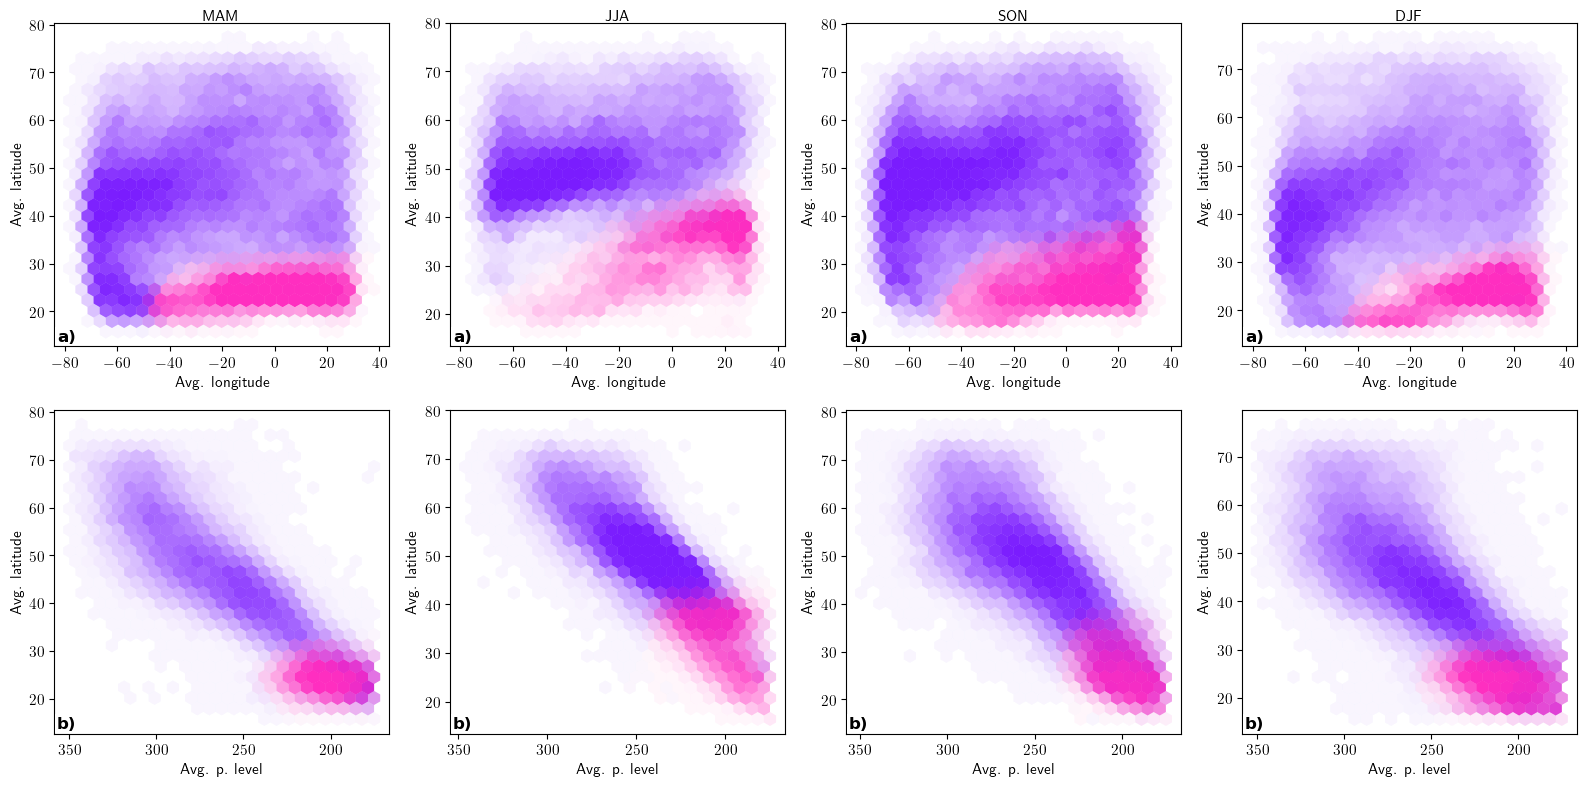

In [32]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS, MeanShift


PINKPURPLE = LinearSegmentedColormap.from_list("pinkpurple", [COLORS[2], COLORS[1]])
plt.ion()

def to_zero_one(X):
    Xmin = X.min(axis=0)
    Xmax = X.max(axis=0)
    
    return (X - Xmin[None, :]) / (Xmax - Xmin)[None, :], Xmin, Xmax


def revert_zero_one(X, Xmin, Xmax):
    return Xmin[None, :] + (Xmax - Xmin)[None, :] * X

fig, axes = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)
feature_names = ["mean_lat", "mean_lon", "mean_lev"]
for season, axs in zip(["MAM", "JJA", "SON", "DJF"], axes.T):
    axs[0].set_title(season)
    X, _ = extract_features(props_as_ds_uncat, feature_names, season)
    X, Xmin, Xmax = to_zero_one(X)
    with Timer():
        labels = GaussianMixture(3).fit_predict(X)
    X = revert_zero_one(X, Xmin, Xmax)

    masks = labels_to_mask(labels)
    mls = []
    for mask in masks.T:
        mls.append(X[mask, 0].mean())
    labels = labels != np.argmin(mls)
    print(np.unique(labels, return_counts=True)[1])
    for ax, feature_ind, letter in zip(axs, [(1, 0), (2, 0)], list("ab")):
        cmap = make_transparent(colormaps.gray_r, nlev=100, n_transparent=0, alpha_others=0.0)
        im1 = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap)

        cmap = make_transparent(PINKPURPLE, nlev=100, n_transparent=0, alpha_others=0.0)
        im2 = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap, C=labels, linewidths=0)

        plt.draw()

        offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
        offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
        mask12 = np.isin(offsets1, offsets2)
        mask21 = np.isin(offsets2, offsets1)
        newalpha = (im1.get_array() / im1.get_array().max() * 2)[mask12]
        im2.set_alpha(np.clip(newalpha, 0.02, 1))
        im2 = ax.add_collection(im2)
        plt.draw()

        try:
            ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
            ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
        except KeyError:
            ax.set_xlabel(feature_names[feature_ind[0]])
            ax.set_ylabel(feature_names[feature_ind[1]])
        if feature_names[feature_ind[0]] == "mean_lev":
            ax.invert_xaxis()
        if feature_names[feature_ind[1]] == "mean_lev":
            ax.invert_yaxis()
        ax.annotate(f"{letter})", (2.2, 4), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=12, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
plt.savefig(f"{FIGURES}/jet_props_misc/is_polar_gmix_JJA.png")

In [33]:
# props_as_ds_uncat = is_polar_gmix(props_as_ds_uncat, ["mean_lat", "mean_lon", "mean_lev"], mode="month")
# props_as_ds = categorize_ds_jets(props_as_ds_uncat)
# props_as_ds_uncat.to_netcdf(exp.path.joinpath("props_as_ds_uncat.nc"))
# props_as_ds.to_netcdf(exp.path.joinpath("props_as_ds.nc"))
# exp.props_over_time(all_jets_over_time, props_as_ds_uncat)

In [34]:
# jet_pos_da = jet_position_as_da(exp.ds["s"], props_as_ds_uncat, all_jets_one_df, exp.path, processes=64, chunksize=100)
# jet_pos_da = coarsen_da(jet_pos_da, 1.5)
# props_as_ds["nao"] = get_nao(props_as_ds)
# overlap = (jet_pos_da > 0).any("lat").all("jet")
# props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")

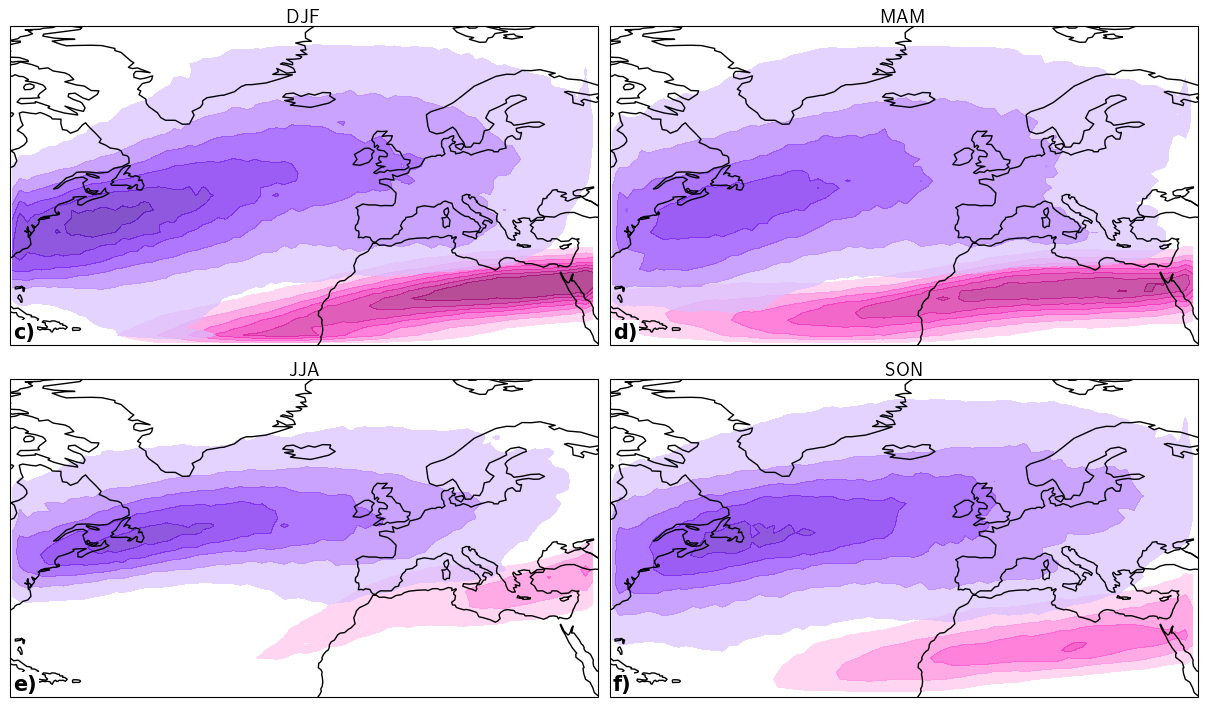

In [35]:
plt.ion()
clear_output()
MYPURPLES = LinearSegmentedColormap.from_list("mypurples", ["#ffffff", COLORS_EXT[4], COLORS_EXT[5]])
MYPINKS = LinearSegmentedColormap.from_list("mypinks", ["#ffffff", COLORS_EXT[7], COLORS_EXT[8]])


clu = Clusterplot(2, 2, exp.region)
to_plot_1 = []
to_plot_2 = []
for season, ax in zip(["DJF", "MAM", "JJA", "SON"], clu.axes.flatten()):
    if season is not None:
        to_plot_1.append(jet_pos_da.sel(time=jet_pos_da.time.dt.season==season, jet="subtropical").mean("time"))
        to_plot_2.append(jet_pos_da.sel(time=jet_pos_da.time.dt.season==season, jet="polar").mean("time"))
    else:
        to_plot_1.append(jet_pos_da.sel(jet="subtropical").mean("time"))
        to_plot_2.append(jet_pos_da.sel(jet="polar").mean("time"))
    season = "all year" if season is None else season
    ax.set_title(season, fontsize=14)
_ = clu.add_contourf([tp1 for tp1 in to_plot_1], transparify=0.7, nlevels=8, cmap=MYPINKS, draw_cbar=False)
_ = clu.add_contourf([tp2 for tp2 in to_plot_2], transparify=0.7, nlevels=8, cmap=MYPURPLES, draw_cbar=False)
clu.resize_relative([0.92, 1.0])
for ax, letter in zip(clu.axes, list("cdef")):
    ax.annotate(f"{letter})", (2.2, 5), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
plt.savefig(f"{FIGURES}/jet_props_misc/is_polar_map.png")